In [28]:
import numpy as np
import matplotlib.pyplot as plt
import gpflow

from vbpp.model import VBPP
from data_down_events_training import make_estimate_data_for_down

def build_data(user, start_line, end_line, filename):
    num_observations = end_line - start_line
    #events_oral = make_estimate_data(user,start_line,end_line,filename)
    #events = np.unique(events_oral.flatten())
    events = make_estimate_data_for_down(user, start_line, end_line, filename)
    #print(len(events))
    return events, num_observations

def domain_grid(domain, num_points):       #域grid
    return np.linspace(domain.min(axis=1), domain.max(axis=1), num_points)

def domain_area(domain):                   #域面积
    return np.prod(domain.max(axis=1) - domain.min(axis=1))

def build_model(events, domain, num_observations, M=20, variance = 1.0, lengthscales = 0.1):
    #kernel = gpflow.kernels.SquaredExponential()
    kernel = gpflow.kernels.SquaredExponential(variance = variance, lengthscales = lengthscales)  #0.01,0.05,0.1,0.2
    Z = domain_grid(domain, M)                               #均匀切分domain,和events无关
    feature = gpflow.inducing_variables.InducingPoints(Z)    #inducing point（将均匀切分的点作为inducing point）
    q_mu = np.zeros(M)      #均值为0？
    q_S = np.eye(M)         #单位矩阵
    #print (events)
    num_events = len(events)
    beta0 = np.sqrt(num_events / domain_area(domain))       # 事件数/域面积 的开方,是什么？  是第二个模型的offset
    model = VBPP(feature, kernel, domain, q_mu, q_S, beta0=beta0, num_events=num_events, num_observations = num_observations)
    return model

In [31]:
N = 100     #预测点（lambda）
#目标用户信息,用于模型训练
object_user = 's052'
object_data_str = 0
object_data_end = 200

variance = 1.0
lengthscales = 0.5
inducing_num = 10

filename = "./data/DSL-StrongPasswordData.xls"
events,num_observations = build_data(object_user,object_data_str, object_data_end,filename)
events = np.array(events, float).reshape(-1, 1)
print(len(events))

domain_max = max(events) + 0.1
domain = [0,domain_max]
domain = np.array(domain, float).reshape(1, 2)

model = build_model(events, domain, num_observations, M=inducing_num, variance=variance, lengthscales = lengthscales)   #M是 inducing point的数量

def objective_closure():                           #目标函数
    return - model.elbo(events)

gpflow.optimizers.Scipy().minimize(objective_closure, model.trainable_variables)

2000


      fun: 405.4054788785492
 hess_inv: <78x78 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.59245207e-02, -9.16565723e-02, -4.91760813e-01,  4.62248604e+00,
       -1.08410677e-01,  4.78378573e-02,  3.54498884e-01, -2.35658475e-01,
       -6.75713742e-02, -2.82585029e-01,  2.09051211e-01, -5.18028998e-01,
       -3.78144357e-02, -1.97963539e-01,  9.81528593e-02, -9.45117481e-01,
       -3.44387866e-02, -5.85999341e-02, -2.25837952e-01,  6.17301640e-02,
       -7.01017837e-02, -1.04712634e-01,  1.39497416e-02,  2.34427107e-03,
       -7.04038865e-02,  6.71393748e-02, -3.65581672e-02,  1.09580032e-02,
        2.37315188e-02, -2.45060086e-02,  3.20539987e-02,  2.18915262e-02,
        9.40469387e-03,  1.32639524e-01,  8.02589804e-02, -3.07300556e-03,
        1.09570011e-02, -1.00400941e-02, -8.70310292e-04, -4.93615490e-03,
       -6.79108290e-03, -4.17259694e-03,  4.04334925e-03,  3.28623231e-01,
        2.31776461e+00,  4.87143642e-01, -3.12009966e-03,  2.67937745e-02,
  

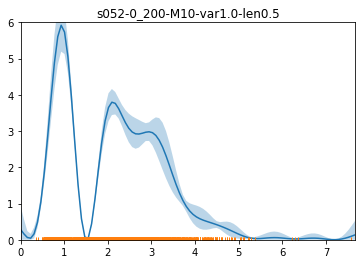

In [32]:
#画强度的估值图
X = domain_grid(domain, N)
lambda_mean, lower, upper = model.predict_lambda_and_percentiles(X)
lower = lower.numpy().flatten()
upper = upper.numpy().flatten()

title = object_user+'-'+str(object_data_str)+'_'+str(object_data_end)+'-M'+ str(inducing_num) + '-var'+ str(variance) + '-len' + str(lengthscales)

plt.title(title)
plt.xlim(X.min(), X.max())
plt.ylim(0, 6)
plt.plot(X, lambda_mean)
plt.fill_between(X.flatten(), lower, upper, alpha=0.3)
plt.plot(events, np.zeros_like(events), '|')
plt.show()

test num is: 0
test num is: 50
test num is: 100
test num is: 150
test num is: 200
test num is: 250
test num is: 300
test num is: 350


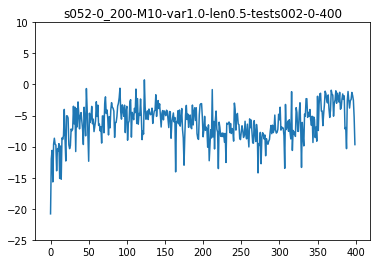

In [33]:
test_data_str = 0
test_data_end = 400
#测试用户数据
test_uset_1 = 's002'

#画预测图
test_data_all = []
for i in range(0,test_data_end):     #预测值显示
    events_for_test, _ = build_data(test_uset_1, test_data_str+i, test_data_str + i + 1, filename)
    events_for_test = np.array(events_for_test, float).reshape(-1, 1)
    test_data_likelihood = model.predict_y(events_for_test, domain, N)
    test_data_all.append(test_data_likelihood)
    #print(test_data_likelihood)
    if i%50 == 0:
        print('test num is:',i)

x_aix = range(test_data_end)
plt.ylim(-25, 10)
title2 = object_user+'-'+str(object_data_str)+'_'+str(object_data_end)+'-M'+ str(inducing_num) + '-var'+ str(variance) + '-len' + str(lengthscales) + '-test' + test_uset_1 + '-' + str(test_data_str) + '-' + str(test_data_end)
plt.title(title2)
plt.plot(x_aix, test_data_all)
plt.show()

test num is: 0
test num is: 50
test num is: 100
test num is: 150
test num is: 200
test num is: 250
test num is: 300
test num is: 350


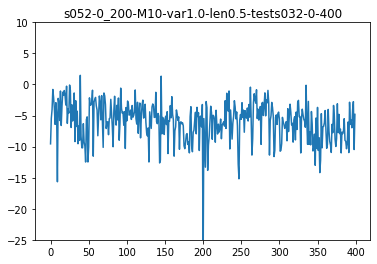

In [34]:
#测试用户数据
test_uset_2 = 's032'

#画预测图
test_data_all = []
for i in range(0,test_data_end):     #预测值显示
    events_for_test, _ = build_data(test_uset_2, test_data_str+i, test_data_str + i + 1, filename)
    events_for_test = np.array(events_for_test, float).reshape(-1, 1)
    test_data_likelihood = model.predict_y(events_for_test, domain, N)
    test_data_all.append(test_data_likelihood)
    #print(test_data_likelihood)
    if i%50 == 0:
        print('test num is:',i)

x_aix = range(test_data_end)
plt.ylim(-25, 10)
title2 = object_user+'-'+str(object_data_str)+'_'+str(object_data_end)+'-M'+ str(inducing_num) + '-var'+ str(variance) + '-len' + str(lengthscales) + '-test' + test_uset_2 + '-' + str(test_data_str) + '-' + str(test_data_end)
plt.title(title2)
plt.plot(x_aix, test_data_all)
plt.show()

test num is: 0
test num is: 50
test num is: 100
test num is: 150
test num is: 200
test num is: 250
test num is: 300
test num is: 350


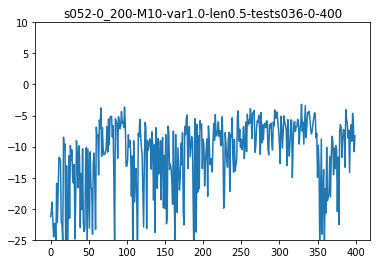

In [35]:
#测试用户数据
test_uset_3 = 's036'

#画预测图
test_data_all = []
for i in range(0,test_data_end):     #预测值显示
    events_for_test, _ = build_data(test_uset_3, test_data_str+i, test_data_str + i + 1, filename)
    events_for_test = np.array(events_for_test, float).reshape(-1, 1)
    test_data_likelihood = model.predict_y(events_for_test, domain, N)
    test_data_all.append(test_data_likelihood)
    #print(test_data_likelihood)
    if i%50 == 0:
        print('test num is:',i)

x_aix = range(test_data_end)
plt.ylim(-25, 10)
title2 = object_user+'-'+str(object_data_str)+'_'+str(object_data_end)+'-M'+ str(inducing_num) + '-var'+ str(variance) + '-len' + str(lengthscales) + '-test' + test_uset_3 + '-' + str(test_data_str) + '-' + str(test_data_end)
plt.title(title2)
plt.plot(x_aix, test_data_all)
plt.show()

test num is: 0
test num is: 50
test num is: 100
test num is: 150
test num is: 200
test num is: 250
test num is: 300
test num is: 350


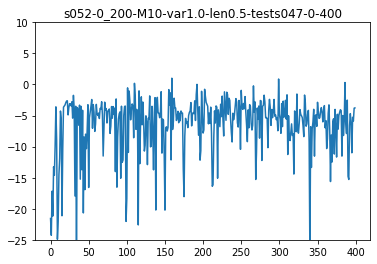

In [36]:
#测试用户数据
test_uset_4 = 's047'

#画预测图
test_data_all = []
for i in range(0,test_data_end):     #预测值显示
    events_for_test, _ = build_data(test_uset_4, test_data_str+i, test_data_str + i + 1, filename)
    events_for_test = np.array(events_for_test, float).reshape(-1, 1)
    test_data_likelihood = model.predict_y(events_for_test, domain, N)
    test_data_all.append(test_data_likelihood)
    #print(test_data_likelihood)
    if i%50 == 0:
        print('test num is:',i)

x_aix = range(test_data_end)
plt.ylim(-25, 10)
title2 = object_user+'-'+str(object_data_str)+'_'+str(object_data_end)+'-M'+ str(inducing_num) + '-var'+ str(variance) + '-len' + str(lengthscales) + '-test' + test_uset_4 + '-' + str(test_data_str) + '-' + str(test_data_end)
plt.title(title2)
plt.plot(x_aix, test_data_all)
plt.show()

test num is: 0
test num is: 50
test num is: 100
test num is: 150
test num is: 200
test num is: 250
test num is: 300
test num is: 350


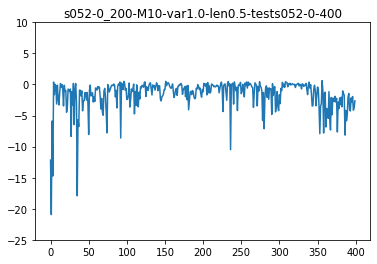

In [37]:
#测试用户数据
test_uset_5 = 's052'

#画预测图
test_data_all = []
for i in range(0,test_data_end):     #预测值显示
    events_for_test, _ = build_data(test_uset_5, test_data_str+i, test_data_str + i + 1, filename)
    events_for_test = np.array(events_for_test, float).reshape(-1, 1)
    test_data_likelihood = model.predict_y(events_for_test, domain, N)
    test_data_all.append(test_data_likelihood)
    #print(test_data_likelihood)
    if i%50 == 0:
        print('test num is:',i)

x_aix = range(test_data_end)
plt.ylim(-25, 10)
title2 = object_user+'-'+str(object_data_str)+'_'+str(object_data_end)+'-M'+ str(inducing_num) + '-var'+ str(variance) + '-len' + str(lengthscales) + '-test' + test_uset_5 + '-' + str(test_data_str) + '-' + str(test_data_end)
plt.title(title2)
plt.plot(x_aix, test_data_all)
plt.show()